In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from scipy.stats import ttest_ind
import json
import os

# Set options

In [2]:
THRESHOLD = 80
batch_corrected = True
nan_remove = True
scaler_term = 'minmax'
scaler = MinMaxScaler() if scaler_term=='minmax' else StandardScaler()

test_enc_name = '_BatchCor'+str(batch_corrected)+'_NanRem'+str(nan_remove)+'_'+str(scaler_term)

# Load config files

In [3]:
with open('data/paths.json','r') as f:
    paths = json.load(f)

data_path = paths["data_path"]

# Get data

In [4]:
df = pd.read_excel(os.path.join(data_path,"raw_data.xlsx"))
n_classes = len(np.unique(df['Lipid Class']))
df.tail()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,MRM Transition of each lipid species\n(Parent ion / Fragment ion),Lipid Species used as Internal Standard,Retention Time\n(min),UNCORRECTED\nPeak Area of Lipid Species,UNCORRECTED\nPeak Area of Internal Standard,UNCORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight)),BATCH CORRECTED\nPeak Area of Lipid Species,BATCH CORRECTED\nPeak Area of Internal Standard,BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))
82147,83,11/2022,T36F3,F,84,deltamethrin,striatum,60,T36,PG(20:0_20:4)-H,PG,825.6 / 303.2,PG(15:0_18:1)-Hd7_SPLASH.IS,0.0,NaN,4986258.0,NaN,NaN,71757909.0,NaN
82148,83,11/2022,T36F3,F,84,deltamethrin,striatum,60,T36,PG(20:0_20:5)-H,PG,823.5 / 301.2,PG(15:0_18:1)-Hd7_SPLASH.IS,0.0,NaN,4986258.0,NaN,NaN,71757909.0,NaN
82149,83,11/2022,T36F3,F,84,deltamethrin,striatum,60,T36,PG(20:0_22:4)-H,PG,853.6 / 331.3,PG(15:0_18:1)-Hd7_SPLASH.IS,0.0,NaN,4986258.0,NaN,NaN,71757909.0,NaN
82150,83,11/2022,T36F3,F,84,deltamethrin,striatum,60,T36,PG(20:0_22:5)-H,PG,851.6 / 329.2,PG(15:0_18:1)-Hd7_SPLASH.IS,0.0,NaN,4986258.0,NaN,NaN,71757909.0,NaN
82151,83,11/2022,T36F3,F,84,deltamethrin,striatum,60,T36,PG(20:0_22:6)-H,PG,849.6 / 327.2,PG(15:0_18:1)-Hd7_SPLASH.IS,0.0,NaN,4986258.0,NaN,NaN,71757909.0,NaN


In [5]:
#sum(df.groupby('Sample Name')['Sample Submission Date'].unique() == '11/2022')
df['Individual Lipid Species'].nunique()
df.shape

(82152, 20)

## COUNTING THE NAN

In [6]:
#with open(os.path.join('data/','significant_lipids_pls2_treatment'+test_enc_name+'.txt'), 'w') as f:
nan_in_first_batch = df[df['Sample Submission Date'] == '09/2021']['BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))'].isna().sum()
nan_in_second_batch = df[df['Sample Submission Date'] == '11/2022']['BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))'].isna().sum()
percentage_nan_first_batch = nan_in_first_batch / len(df[df['Sample Submission Date'] == '09/2021']) * 100
percentage_nan_second_batch = nan_in_second_batch / len(df[df['Sample Submission Date'] == '11/2022']) * 100
print(f'Percentage of NAN in First Batch: {percentage_nan_first_batch}')
print(f'Percentage of NAN in Second Batch: {percentage_nan_second_batch}')

nan_in_first_batch_control = df[(df['Sample Submission Date'] == '09/2021') & (df['Treatment'] == 'control')]['BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))'].isna().sum()
nan_in_first_batch_deltamethrin = df[(df['Sample Submission Date'] == '09/2021') & (df['Treatment'] == 'deltamethrin')]['BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))'].isna().sum()
nan_in_second_batch_control = df[(df['Sample Submission Date'] == '11/2022') & (df['Treatment'] == 'control')]['BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))'].isna().sum()
nan_in_second_batch_deltamethrin = df[(df['Sample Submission Date'] == '11/2022') & (df['Treatment'] == 'deltamethrin')]['BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))'].isna().sum()
percentage_nan_first_batch_control = nan_in_first_batch_control / len(df[(df['Sample Submission Date'] == '09/2021') & (df['Treatment'] == 'control')]) * 100
percentage_nan_first_batch_deltamethrin = nan_in_first_batch_deltamethrin / len(df[(df['Sample Submission Date'] == '09/2021') & (df['Treatment'] == 'deltamethrin')]) * 100
percentage_nan_second_batch_control = nan_in_second_batch_control / len(df[(df['Sample Submission Date'] == '11/2022') & (df['Treatment'] == 'control')]) * 100
percentage_nan_second_batch_deltamethrin = nan_in_second_batch_deltamethrin / len(df[(df['Sample Submission Date'] == '11/2022') & (df['Treatment'] == 'deltamethrin')]) * 100

print(f'Percentage of NAN in First Batch Control: {percentage_nan_first_batch_control} vs Percentage of NAN in First Batch Deltamethrin: {percentage_nan_first_batch_deltamethrin}')
print(f'Percentage of NAN in Second Batch Control: {percentage_nan_second_batch_control} vs Percentage of NAN in Second Batch Deltamethrin: {percentage_nan_second_batch_deltamethrin}')


Percentage of NAN in First Batch: 46.13643003213556
Percentage of NAN in Second Batch: 49.11627227578148
Percentage of NAN in First Batch Control: 45.64709319310546 vs Percentage of NAN in First Batch Deltamethrin: 46.62576687116564
Percentage of NAN in Second Batch Control: 49.0724510663161 vs Percentage of NAN in Second Batch Deltamethrin: 49.16009348524686


95       14364
96       14364
97       14364
98       14364
99       14364
         ...  
81546    14364
81547    14364
81548    14364
81549    14364
81550    14364
Name: Nan_Counts_FirstBatch, Length: 32040, dtype: int64
95       5834
96       5834
97       5834
98       5834
99       5834
         ... 
81546    5834
81547    5834
81548    5834
81549    5834
81550    5834
Name: Nan_Counts_SecondBatch, Length: 32040, dtype: int64


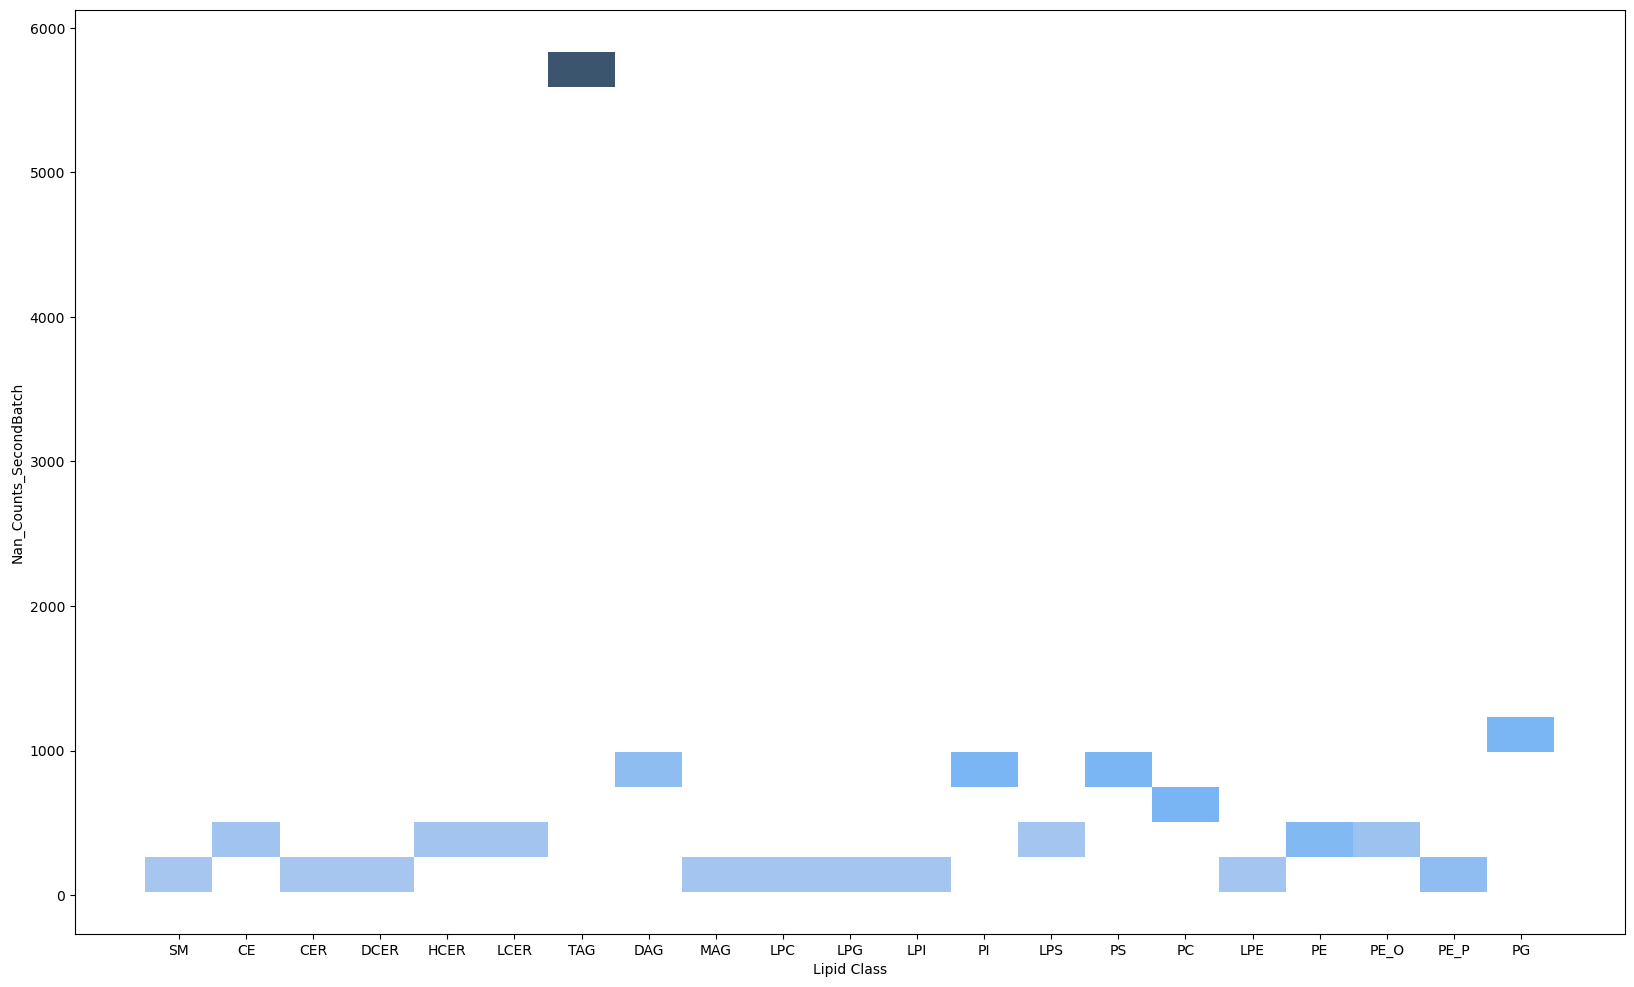

In [32]:
#df[df['BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))'] == pd.np.nan].hist(by=df['Lipid Class'])
df['Nan_Counts_FirstBatch'] = df[df['Sample Submission Date'] == '09/2021']['BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))'].isnull()
df['Nan_Counts_FirstBatch'] = df.groupby('Lipid Class')['Nan_Counts_FirstBatch'].transform('sum').astype(int)
df['Nan_Counts_SecondBatch'] = df[df['Sample Submission Date'] == '11/2022']['BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))'].isnull()
df['Nan_Counts_SecondBatch'] = df.groupby('Lipid Class')['Nan_Counts_SecondBatch'].transform('sum').astype(int)
plt.figure(figsize=(20,12))
sns.histplot(df, x='Lipid Class', y='Nan_Counts_SecondBatch')
print(df[df['Lipid Class'] == 'TAG']['Nan_Counts_FirstBatch'])
print(df[df['Lipid Class'] == 'TAG']['Nan_Counts_SecondBatch'])


In [38]:
df['nan'] = df['BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))'].isnull()
df.groupby('Lipid Class')['nan'].sum()
df.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,...,UNCORRECTED\nPeak Area of Lipid Species,UNCORRECTED\nPeak Area of Internal Standard,UNCORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight)),BATCH CORRECTED\nPeak Area of Lipid Species,BATCH CORRECTED\nPeak Area of Internal Standard,BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight)),Nan_Counts,Nan_Counts_FirstBatch,Nan_Counts_SecondBatch,nan
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,...,4.116176e+06,6.142877e+07,0.001197,1.963161e+06,4.165659e+07,0.000842,220,148,72,False
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,...,2.433723e+07,6.142877e+07,0.007075,1.490595e+07,4.165659e+07,0.006390,220,148,72,False
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,...,1.432478e+08,6.142877e+07,0.041642,8.628739e+07,4.165659e+07,0.036989,220,148,72,False
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,...,1.268323e+08,6.142877e+07,0.036870,1.080535e+08,4.165659e+07,0.046320,220,148,72,False
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,...,5.419340e+06,6.142877e+07,0.001575,2.723486e+06,4.165659e+07,0.001167,220,148,72,False


## Select normalized or unnormalized data

In [6]:
metadata = df.iloc[:,:11]
if batch_corrected:
    data = pd.concat([metadata, df.iloc[:,19]],axis=1)
else:
    data = pd.concat([metadata, df.iloc[:,16]],axis=1)
data.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167


## Selecting Specific Data

In [7]:
data = data[data['Tissue Type'] == 'striatum']
data.head()

,Sample Number,Sample Submission Date,Sample Name,Sex,Tissue weight (mg),Treatment,Tissue Type,PND,Litter,Individual Lipid Species,Lipid Class,BATCH CORRECTED\nNormalized Peak Area (Peak Area of Lipid Species / (Peak Area of Internal Standard * Tissue weight))
0,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(14:0)+H,SM,0.000842
1,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(16:0)+H,SM,0.006390
2,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:0)+H,SM,0.036989
3,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(18:1)+H,SM,0.046320
4,1,09/2021,C20M1S,M,56,control,striatum,30,C20,SM(20:0)+H,SM,0.001167


## Organize pivot table

In [8]:
data_pivot = data.pivot(index=['Sample Name', 'Sex', 'Treatment', 'PND', 'Tissue Type', 'Sample Submission Date'], columns='Individual Lipid Species', values=data.columns[-1])
tot_lipids = data_pivot.shape[1] - 6

## Manage NaN

In [9]:
if nan_remove:
    data_stats = data_pivot.reset_index().dropna(axis=1, thresh=0.9*data_pivot.shape[0]).fillna(1e-3*np.min(np.abs(data.iloc[:,-1])))
else:
    data_stats = data_pivot.reset_index().fillna(1e-3*np.min(np.abs(data.iloc[:,-1])))
data_stats.head()
lipids_ok = list(data_stats.columns[6:])

## Encode batch

In [10]:
data_stats['Sample Submission Date'] = LabelEncoder().fit_transform(data_stats['Sample Submission Date'])
data_stats['Treatment'] = LabelEncoder().fit_transform(data_stats['Treatment'])
data_stats['Sample Submission Date'].unique()

array([0, 1])

## Log transform

In [11]:
data_np = data_stats.values[:,6:]
data_np = np.log10(data_np.astype('float64'))
print(data_np.shape)

(48, 379)


## Visualize data distribution

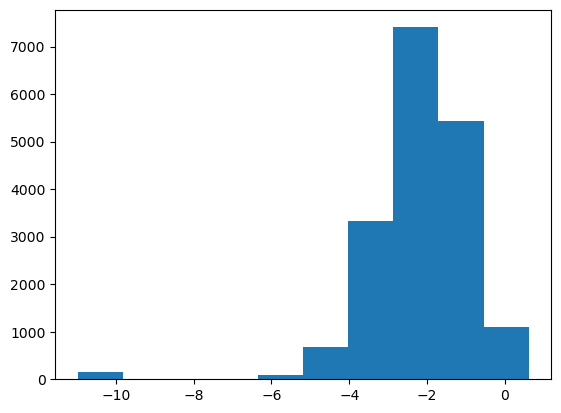

In [12]:
plt.figure()
plt.hist(data_np.flatten())
plt.show()

# Normalize data

In [13]:
data_norm = scaler.fit_transform(data_np)

## Visualize normalized data distribution

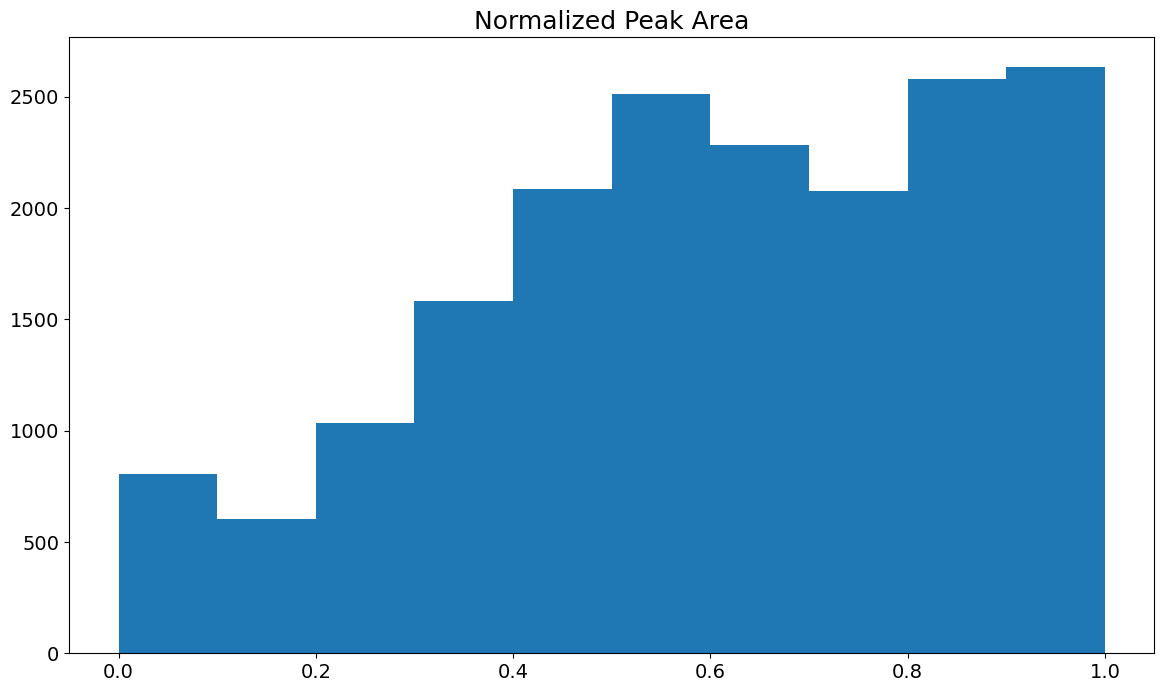

In [15]:
fig = plt.figure(figsize=(14,8), dpi=100)
plt.hist(data_norm.flatten())
plt.title('Normalized Peak Area', fontdict={'fontsize':18})
plt.tick_params(axis='both', which='major', labelsize=14)
fig.savefig(os.path.join(data_path,"only-striatum/li-histogram_normalized_peak_area.png"), format='png', facecolor='w')

# PCA

In [18]:
pca = PCA()
data_pca = pca.fit_transform(data_norm)
print(data_pca.shape)

(36, 36)


## Latent curve

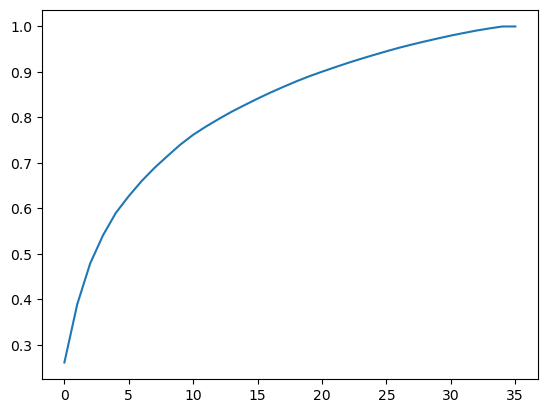

In [19]:
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.show()

# T-test

In [20]:
p_values = [
    [
        d,
        ttest_ind(data_pca[data_stats['Sample Submission Date']==0, d], data_pca[data_stats['Sample Submission Date']==1, d])[1],
        ttest_ind(data_pca[data_stats['Treatment']==0, d], data_pca[data_stats['Treatment']==1, d])[1],
    ]
    for d in range(data_pca.shape[1])
]
p_values = np.asarray(p_values)
print(p_values.shape)

(36, 3)


/tmp/ipykernel_100221/260942847.py:4: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_ind(data_pca[data_stats['Sample Submission Date']==0, d], data_pca[data_stats['Sample Submission Date']==1, d])[1],
/tmp/ipykernel_100221/260942847.py:5: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  ttest_ind(data_pca[data_stats['Treatment']==0, d], data_pca[data_stats['Treatment']==1, d])[1],


# Visualize data after PCA

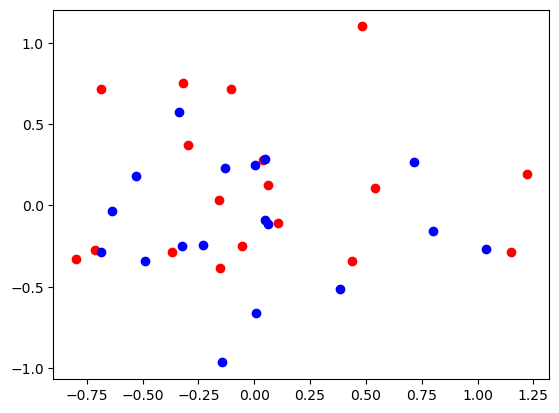

In [21]:
plt.scatter(data_pca[data_stats['Treatment']==0, 14], data_pca[data_stats['Treatment']==0, 21],c="red")
plt.scatter(data_pca[data_stats['Treatment']==1, 14], data_pca[data_stats['Treatment']==1, 21],c="blue")
plt.show()

# Isolate significant PCs

In [22]:
print(f'{np.sum(p_values[:,1]<0.05)} significant pc with respect to date')
print(f'{np.sum(p_values[:,2]<0.05)} significant pc with respect to date')
print(f'{np.sum((p_values[:,2]<0.05)*(p_values[:,1]<0.05))} significant pc with respect to both')

significant_pc = np.where(p_values[:,2]<0.05)[0]

2 significant pc with respect to date
1 significant pc with respect to date
0 significant pc with respect to both


# Isolate significant lipids

In [23]:
significant_components = pca.components_[significant_pc,:]
print(significant_components.shape)
max_values = np.max(np.abs(significant_components), axis=0)
print(max_values.shape)

(1, 369)
(369,)


In [24]:
ths = np.percentile(np.abs(pca.components_.flatten()), THRESHOLD)
idx_significant_lipids = np.where(max_values>ths)[0]
n_significant_lipids = len(idx_significant_lipids)
print(f'{n_significant_lipids} ({n_significant_lipids/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids = [lipids_ok[i] for i in idx_significant_lipids]

71 (6.26% of original total) significant lipids found


In [25]:
lipid_classes = np.unique([lipids_ok[i].split('(')[0] for i in idx_significant_lipids])
print(f'{len(lipid_classes)} ({len(lipid_classes)/n_classes*100:.2f}% of original total) lipid classes found')
print(lipid_classes)

13 (61.90% of original total) lipid classes found
['CER' 'DAG' 'DCER' 'HCER' 'LPC' 'LPE' 'PC' 'PE' 'PG' 'PI' 'PS' 'SM' 'TAG']


In [26]:
date_pc = np.where(p_values[:,1]<0.05)[0]
significant_components = pca.components_[date_pc,:]
max_values = np.max(np.abs(significant_components), axis=0)

idx_significant_lipids = np.where(max_values>ths)[0]
n_significant_lipids = len(idx_significant_lipids)
print(f'{n_significant_lipids} ({n_significant_lipids/tot_lipids*100:.2f}% of original total) date dependent lipids found')
date_lipids = [lipids_ok[i] for i in idx_significant_lipids]

146 (12.86% of original total) date dependent lipids found


## Save results

In [28]:
with open(os.path.join('results/only-females/','significant_lipid'+test_enc_name+'.txt'), 'w') as f:
    for l in significant_lipids:
        f.write(l+'\n')

with open(os.path.join('results/only-females/','date_lipids'+test_enc_name+'.txt'), 'w') as f:
    for l in date_lipids:
        f.write(l+'\n')

with open(os.path.join('results/only-females/','significant_lipid_classes'+test_enc_name+'.txt'), 'w') as f:
    for l in lipid_classes:
        f.write(l+'\n')

### EXAMPLE WITH PARTIAL LEAST SQUARE - DA

In [16]:
from sklearn.cross_decomposition import PLSRegression
pls2_treatment = PLSRegression(n_components=72, scale = False)
pls2_date = PLSRegression(n_components=72, scale = False)
data_pls2_treatment = pls2_treatment.fit_transform(data_norm, data_stats['Treatment'].values)
data_pls2_date = pls2_date.fit_transform(data_norm, data_stats['Sample Submission Date'].values)


/home/ivan/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 39
  warnings.warn(f"Y residual is constant at iteration {k}")
/home/ivan/anaconda3/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:305: UserWarning: Y residual is constant at iteration 39
  warnings.warn(f"Y residual is constant at iteration {k}")


In [17]:
p_values_pls2 = [
    [
        d,
        ttest_ind(data_pls2_treatment[0][data_stats['Sample Submission Date']==0, d], data_pls2_treatment[0][data_stats['Sample Submission Date']==1, d])[1],
        ttest_ind(data_pls2_treatment[0][data_stats['Treatment']==0, d], data_pls2_treatment[0][data_stats['Treatment']==1, d])[1],
    ]
    for d in range(data_pls2_treatment[0].shape[1])
]
p_values_pls2 = np.asarray(p_values_pls2)
print(p_values_pls2.shape)

(72, 3)


In [18]:
data_pls2_treatment[0]  

array([[ 0.6964803 ,  0.82989065, -1.35629311, ...,  0.        ,
         0.        ,  0.        ],
       [-2.51771841,  0.06165182,  0.28597811, ...,  0.        ,
         0.        ,  0.        ],
       [-0.68667748, -0.49631199, -1.96887025, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.61699422, -1.31450219, -0.89245654, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.43894908, -0.00336592, -0.04284723, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.05832118, -1.31084991,  0.78599769, ...,  0.        ,
         0.        ,  0.        ]])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


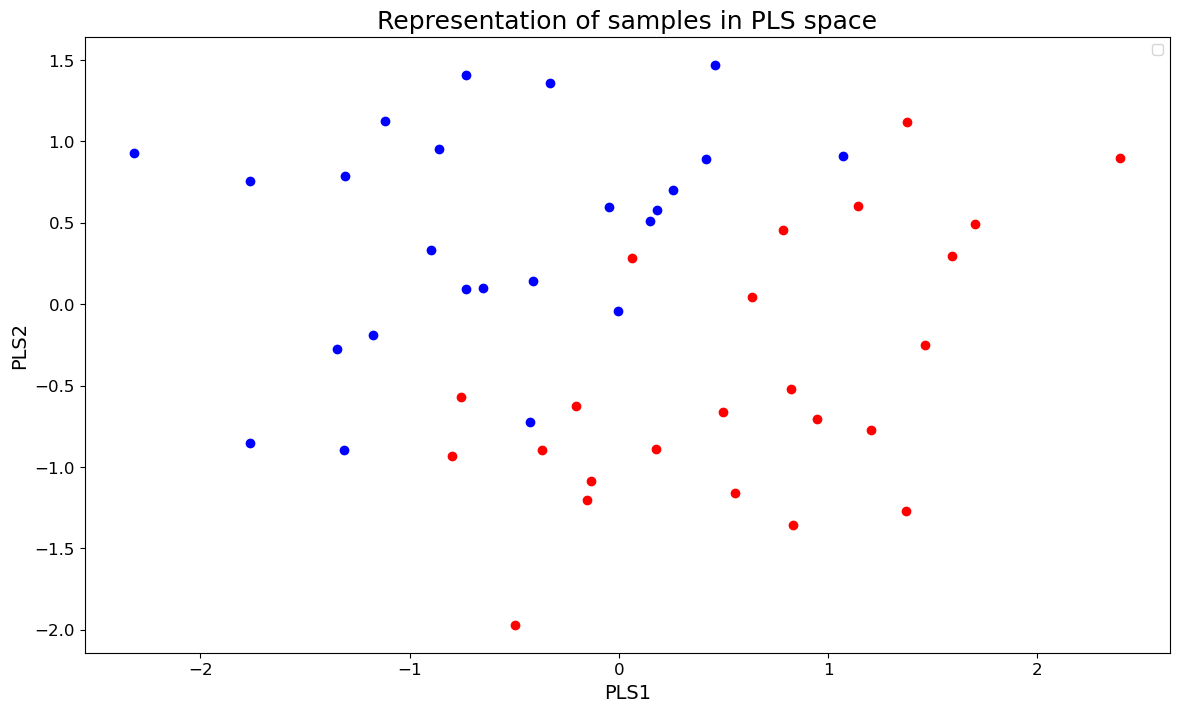

In [19]:
fig = plt.figure(figsize=(14,8), dpi=100)
plt.scatter(data_pls2_treatment[0][data_stats['Treatment']==0, 1], data_pls2_treatment[0][data_stats['Treatment']==0, 2],c="red")
plt.scatter(data_pls2_treatment[0][data_stats['Treatment']==1, 1], data_pls2_treatment[0][data_stats['Treatment']==1, 2],c="blue")
plt.legend()
plt.title('Representation of samples in PLS space', fontdict={'fontsize':18})
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('PLS1', fontdict={'fontsize':14})
plt.ylabel('PLS2', fontdict={'fontsize':14})
fig.savefig(os.path.join(data_path,"only-striatum/li-sample_distribution_PLS_space.png"), format='png', facecolor='w', dpi=100)

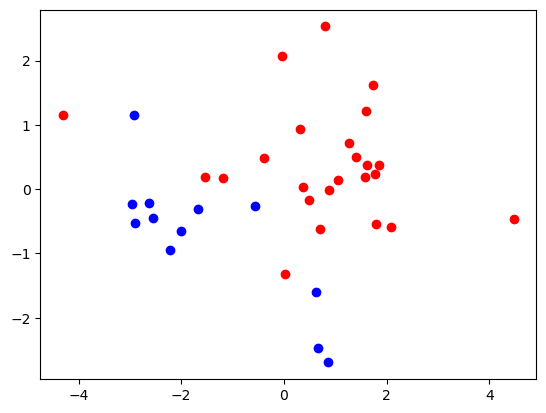

In [33]:
plt.scatter(data_pls2_date[0][data_stats['Sample Submission Date']==0, 0], data_pls2_date[0][data_stats['Sample Submission Date']==0, 1],c="red")
plt.scatter(data_pls2_date[0][data_stats['Sample Submission Date']==1, 0], data_pls2_date[0][data_stats['Sample Submission Date']==1, 1],c="blue")
plt.show()

In [20]:
print(f'{np.sum(p_values_pls2[:,1]<0.05)} significant pc with respect to date')
print(f'{np.sum(p_values_pls2[:,2]<0.05)} significant pc with respect to TREATMENT')
print(f'{np.sum((p_values_pls2[:,2]<0.05)*(p_values_pls2[:,1]<0.05))} significant pc with respect to both')

significant_pc_pls2_treatment = np.where(p_values_pls2[:,2]<0.05)[0]
significant_pc_pls2_date = np.where(p_values_pls2[:,1]<0.05)[0]
print(significant_pc_pls2_treatment)
print(significant_pc_pls2_date)

3 significant pc with respect to date
4 significant pc with respect to TREATMENT
2 significant pc with respect to both
[0 1 2 3]
[ 0  1 10]


In [21]:
# we have 372x72 so 372 lypids composing each of the 72 components. We ahve to transapose them and isolate the components identified as the most significants
significant_components_pls2_treatment = pls2_treatment.x_weights_.T[significant_pc_pls2_treatment,:]
# and then we get the 372 highest lypids avlues acroos all th selcted components
max_values_pls2_treatment = np.max(np.abs(significant_components_pls2_treatment), axis = 0)

In [22]:
ths_pls2_treatment = np.percentile(np.abs(pls2_treatment.x_weights_.T), THRESHOLD)

In [23]:
ths_pls2_treatment

0.043412711282292474

In [24]:
idx_significant_lipids_pls2_treatment = np.where(max_values_pls2_treatment>ths_pls2_treatment)[0]
n_significant_lipids_pls2_treatment = len(idx_significant_lipids_pls2_treatment)
print(f'{n_significant_lipids_pls2_treatment} ({n_significant_lipids_pls2_treatment/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids_pls2_treatment = [lipids_ok[i] for i in idx_significant_lipids_pls2_treatment]
print(idx_significant_lipids_pls2_treatment)

331 (29.16% of original total) significant lipids found
[  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  24  25  26  27  29  30  31  32  33  34  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  51  52  53  54  56  57  58  59
  60  61  62  63  64  65  66  67  68  70  71  72  73  74  75  76  77  78
  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96
  98  99 100 101 102 103 104 105 108 109 110 111 112 113 114 115 117 118
 119 120 121 122 123 124 126 127 128 130 131 132 133 134 135 136 137 138
 139 140 142 143 144 145 146 147 148 149 150 152 154 155 156 157 158 159
 160 161 162 163 164 166 167 168 169 170 171 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 226 227 228 230 231 232 233 234 235 236
 237 239 240 242 243 244 245 246 247 248 249 251 252 253 254 255 256

In [25]:
#significant_components_pls2_date = pls2_date.x_weights_.T[significant_pc_pls2_date,:]
#max_values_pls2_date = np.max(np.abs(significant_components_pls2_date), axis = 0)

significant_components_pls2_date = pls2_treatment.x_weights_.T[significant_pc_pls2_date,:]
max_values_pls2_date = np.max(np.abs(significant_components_pls2_date), axis = 0)

In [26]:
# we actually don'tneed this if we are working with the treatment components
#ths_pls2_date = np.percentile(np.abs(pls2_treatment.x_weights_.T), THRESHOLD)

In [27]:
""" idx_significant_lipids_pls2_date = np.where(max_values_pls2_date>ths_pls2_date)[0]
n_significant_lipids_pls2_date = len(idx_significant_lipids_pls2_date)
print(f'{n_significant_lipids_pls2_date} ({n_significant_lipids_pls2_date/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids_pls2_date = [lipids_ok[i] for i in idx_significant_lipids_pls2_date] """

idx_significant_lipids_pls2_date = np.where(max_values_pls2_date>ths_pls2_treatment)[0]
n_significant_lipids_pls2_date = len(idx_significant_lipids_pls2_date)
print(f'{n_significant_lipids_pls2_date} ({n_significant_lipids_pls2_date/tot_lipids*100:.2f}% of original total) significant lipids found')
significant_lipids_pls2_date = [lipids_ok[i] for i in idx_significant_lipids_pls2_date]

307 (27.05% of original total) significant lipids found


In [28]:
lipid_classes_pls2_treatment = np.unique([lipids_ok[i].split('(')[0] for i in idx_significant_lipids_pls2_treatment])
print(f'{len(lipid_classes_pls2_treatment)} ({len(lipid_classes_pls2_treatment)/n_classes*100:.2f}% of original total) lipid classes found')
print(lipid_classes_pls2_treatment)

17 (80.95% of original total) lipid classes found
['CE' 'CER' 'DAG' 'DCER' 'HCER' 'LPC' 'LPE' 'LPG' 'LPI' 'MAG' 'PC' 'PE'
 'PG' 'PI' 'PS' 'SM' 'TAG']


In [29]:
lipid_classes_pls2_date = np.unique([lipids_ok[i].split('(')[0] for i in idx_significant_lipids_pls2_date])
print(f'{len(lipid_classes_pls2_date)} ({len(lipid_classes_pls2_date)/n_classes*100:.2f}% of original total) lipid classes found')
print(lipid_classes_pls2_date)

18 (85.71% of original total) lipid classes found
['CE' 'CER' 'DAG' 'DCER' 'HCER' 'LPC' 'LPE' 'LPG' 'LPI' 'LPS' 'MAG' 'PC'
 'PE' 'PG' 'PI' 'PS' 'SM' 'TAG']


In [30]:
unique_set_treatment = set(significant_lipids_pls2_treatment).difference(set(significant_lipids_pls2_date))
unique_list_treatment = list(unique_set_treatment)
len(unique_list_treatment)

41

In [32]:
with open(os.path.join('results/only-striatum/','significant_lipids_pls2_treatment'+test_enc_name+'.txt'), 'w') as f:
    for l in significant_lipids_pls2_treatment:
        f.write(l+'\n')

In [ ]:
with open(os.path.join('results/only-striatum/','significant_lipids_pls2_date'+test_enc_name+'.txt'), 'w') as f:
    for l in significant_lipids_pls2_date:
        f.write(l+'\n')

In [ ]:
with open(os.path.join('results/only-striatum/','significant_lipids_pls2_unique_treatment'+test_enc_name+'.txt'), 'w') as f:
    for l in unique_list_treatment:
        f.write(l+'\n')